# GleanerIO SHACL multisite processor

## About

Ted Habberman presented to the CDF on ISO metadata analysis.  I have been exploring some approaches to accessing the FAIR Digital Object server that is part of the standard setup supporting GeoCODES and other groups.  Leveraging Python Dask and S3 Boto it is easy to access these object stores in a highly performant manner.  

In addition to DASK there is S3SELECT as well as SPARQL calls on objects and triplestores.  

## Notes

Curious above local context file reading when doing lots of calls.  PyLD seems to know to do caching but not sure how it could in a Dask based pattern.

May need to explore approach to read local files for context like

## Imports


In [1]:
import boto3
import pandas as pd
import json
import s3fs
import kglab
import seaborn as sns
from rdflib import Graph  #, plugin
import getpass
import plotly.express as px
from tqdm import tnrange
from matplotlib import pyplot as plt
import dask
from dask.distributed import Client
import dask.dataframe as dd
import dask.multiprocessing

## Set up Dask client

In [2]:
from dask.distributed import Client    #, progress
client = Client(threads_per_worker=5, n_workers=4)
client

distributed.diskutils - INFO - Found stale lock file and directory '/home/fils/Containers/dvols/jupyter/work/Gleaner/notebooks/validation/dask-worker-space/worker-y2aonh4a', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/fils/Containers/dvols/jupyter/work/Gleaner/notebooks/validation/dask-worker-space/worker-cndiq331', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/fils/Containers/dvols/jupyter/work/Gleaner/notebooks/validation/dask-worker-space/worker-ljl_659p', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/fils/Containers/dvols/jupyter/work/Gleaner/notebooks/validation/dask-worker-space/worker-lm_pc475', purging


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 20,Total memory: 31.17 GiB
Comm: tcp://127.0.0.1:35335,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.17 GiB
Comm: tcp://127.0.0.1:45279,Total threads: 5
Dashboard: http://127.0.0.1:41999/status,Memory: 7.79 GiB
Nanny: tcp://127.0.0.1:40889,


## File Access

In [2]:
# Set the shapegraph to use
sg = './shapes/geocodes_dcscan.ttl'

## Anonymous S3 File system
oss = s3fs.S3FileSystem(
    anon=True,
    client_kwargs = {"endpoint_url":"https://oss.geodex.org"}
)

## Access controlled s3
# session = boto3.Session(profile_name='default' ,   region_name="us-east-1")
# s3 = session.client('s3')  # needed later for listing objects
# s3r = session.resource('s3')
# oss = s3fs.S3FileSystem( profile="default")

## Manual code access
# ACCESS_CODE = getpass.getpass()
# SECRET_CODE = getpass.getpass()

# oss = s3fs.S3FileSystem(
#     anon=False,
#     key=ACCESS_CODE,
#     secret=SECRET_CODE,
#     client_kwargs = {"endpoint_url":"http://192.168.86.45:49159"}
# )

In [4]:
# [optional] List the directories we can work with later
sumlist = oss.ls('gleaner/summoned') # gleaner.oih/summoned/
print(sumlist)
print(len(sumlist))

# for testing, set to a smaller subset

# sumlist = ['gleaner/summoned/lipdverse', 'gleaner/summoned/magic', 'gleaner/summoned/hydroshare']

['gleaner/summoned/bcodmo', 'gleaner/summoned/cchdo', 'gleaner/summoned/earthchem', 'gleaner/summoned/edi', 'gleaner/summoned/getiedadataorg', 'gleaner/summoned/hydroshare', 'gleaner/summoned/ieda', 'gleaner/summoned/iris', 'gleaner/summoned/linkedearth', 'gleaner/summoned/lipdverse', 'gleaner/summoned/magic', 'gleaner/summoned/ocd', 'gleaner/summoned/opentopo', 'gleaner/summoned/ssdb', 'gleaner/summoned/ucar', 'gleaner/summoned/unavco', 'gleaner/summoned/wikilinkedearth', 'gleaner/summoned/wwwbco-dmoorg', 'gleaner/summoned/wwwhydroshareorg']
19


### Definitions

In [10]:
# some color coding for pandas for later
def change_color_group(x):
    dfcg = x.copy()
    dfcg.loc[df['severity'] == "shacl:Violation", :] = 'background-color: #F89782'
    dfcg.loc[df['severity'] == "shacl:Warning", :] = 'background-color: #F0F480'
    dfcg.loc[df['severity'] == "shacl:Info", :] = 'background-color: #CBFBD2'
    return dfcg

In [11]:
## need a SPARQL for counts of the various validations


bc = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX sh: <http://www.w3.org/ns/shacl#>
SELECT  ?tid ?b
  WHERE {
    ?tid rdf:type sh:ValidationReport .
    ?tid sh:conforms ?b .
  }

"""

ccount = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX sh: <http://www.w3.org/ns/shacl#>
SELECT  ?b (COUNT(?tid) as ?tcount)
  WHERE {
    ?tid rdf:type sh:ValidationReport .
    ?tid sh:conforms ?b .
  }

group by (?b)
"""

scount = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX sh: <http://www.w3.org/ns/shacl#>
SELECT  ?severity (COUNT(?id) as ?tcount)
  WHERE {
    ?id rdf:type sh:ValidationResult .
    ?id sh:resultSeverity ?severity .
  }
group by (?severity)

"""





In [12]:
# SHACL function
@dask.delayed()
def read_and_validate(fn):
    # make a kg to hold our data graph
    namespaces = {
        "schema":  "https://schema.org/",
        "shacl":   "http://www.w3.org/ns/shacl#" ,
    }

    kg = kglab.KnowledgeGraph(
        name = "Schema.org based datagraph",
        base_uri = "https://example.org/id/",
        namespaces = namespaces,
    )

    ## this is a mess.   no need to load to a graph objet to validate.  also, 
    ## can we load up the graph first and then validate later for everythng?
    with oss.open(fn, 'rb') as f:
        jld = json.loads(f.read().decode("utf-8", "ignore").replace('\n',' '))
        jlds = json.dumps(jld)

        g = Graph().parse(data=jlds, format='json-ld')
        context = {
            "@vocab": "https://schema.org/",
        }

        ttl = g.serialize(format='ttl', context=context, indent=4)
        kg.load_rdf_text(ttl, format="ttl", base=None)

        conforms, report_graph, report_text = kg.validate(
            shacl_graph=sg,
            shacl_graph_format="ttl"
        )

        return report_graph.save_rdf_text()  # return graph object or string of graph

## Get files


### Multi Source Loop

In [13]:
%%time
## Loop all items in summoned prefix

allresults = []

# hack to remove some problematic ones
try:
    sumlist.remove("gleaner/summoned/bcodmo")
except:
    print("bcodmo, note present..")
    
for item in sumlist:
    try:
        print(item)
        fns = oss.ls(item)
        o = []
        # o = [read_and_validate(f) for f in fns]  # need to skip error file ".jsonld"
        for f in fns:
                temp = read_and_validate(f)
                o.append(temp)
        results = dask.compute(*o)
        allresults.append(results)
    except:
        print("ERROR")
        print(item)

# fns = oss.ls(checkPrefix)
# o = [read_and_validate(f) for f in fns]
# results = dask.compute(*o)

gleaner/summoned/cchdo
gleaner/summoned/earthchem


distributed.worker - WARNING - Compute Failed
Function:  read_and_validate
args:      ('gleaner/summoned/earthchem/.jsonld')
kwargs:    {}
Exception: JSONDecodeError('Expecting value: line 1 column 2 (char 1)')



ERROR
gleaner/summoned/earthchem
gleaner/summoned/edi


distributed.worker - WARNING - Compute Failed
Function:  read_and_validate
args:      ('gleaner/summoned/edi/.jsonld')
kwargs:    {}
Exception: UnicodeDecodeError('utf-8', b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x02\xff\xacXmo\xdc6\x12\xfe|\xfe\x15\x8c\xbex}XI^\xe7\xda\xde\xc5\xbb\x8bs\xeb&\xce\xe1\x9a\x04\xe7\xb4E\x10\x04\x07J\xe2J\xb4%Q!\xa9]/\x9a\xfe\xf7>CJZ\xc9v\x13\xe0r\x86aK|\x19\xce\xcb33\x0fu\xb4|r\xf9\xfa\x87\xb7\xef\xde\xfc\xc8\n[\x95\xeb\xa3%\xfdc%\xaf\xf3U \xea\x00\x03O\xc2\x90\xbd\x10\xb5\xd0\xdc\x8a\x8cm\xb4\xaa\xd8\x95\xaaDts\xc6\xc2p}\xc4\xf0\xb3,\x04\xcf\xbaG+m)\xd6\xd7i!*\x1e)\x9d\xb3\x90\x8d^\x96\xb1\x9f\xf7\xdb*a9K\x0b\xae\x8d\xb0\xab\xa0\xb5\x9b\xf0\xef\x01\xeb\xe4\xb8\xb9\x9aWb\x15l\xa5\xd85J\xdb\x80\xa5\xaa\xb6\xa2\xc6\xda\x9d\xccl\xb1\xca\xc4V\xa6"t/s&ki%/C\x93\xf2R\xac\x16\xd0\xdd\xe96\x12\x94\t\x93j\xd9X\xa9\xea\x91\xac\x91z\xd20\xce\xa0\x0cS\x1b&\xeep\x94\x91I)\x98q\xd6\x18f\x0bn\x99\xa89\xc6\x0c\xdb\x89\xa4\xe2\xc6\n\x8dq\xc5D\x95\x88\xcc\x1dh\xacnS\xdbj8+\xe3\xb

ERROR
gleaner/summoned/edi
gleaner/summoned/getiedadataorg


distributed.worker - WARNING - Compute Failed
Function:  read_and_validate
args:      ('gleaner/summoned/getiedadataorg/.jsonld')
kwargs:    {}
Exception: JSONDecodeError("Expecting ',' delimiter: line 1 column 2479 (char 2478)")



ERROR
gleaner/summoned/getiedadataorg
gleaner/summoned/hydroshare


distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/distributed/core.py", line 498, in handle_comm
    result = handler(comm, **msg)
  File "/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/distributed/scheduler.py", line 3949, in heartbeat_worker
    ws._executing = {
  File "/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/distributed/scheduler.py", line 3950, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: 'read_and_validate-52b64dc2-0d9d-4b04-9843-ce680e587933'
distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/distributed/core.py", line 498, in handle_comm
    result = handler(comm, **msg)
  File "/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/distributed/scheduler.py", l

gleaner/summoned/ieda


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

ERROR
gleaner/summoned/ieda
gleaner/summoned/iris


distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/distributed/core.py", line 498, in handle_comm
    result = handler(comm, **msg)
  File "/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/distributed/scheduler.py", line 3949, in heartbeat_worker
    ws._executing = {
  File "/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/distributed/scheduler.py", line 3950, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: 'read_and_validate-f8bf332c-75a7-462e-9bb0-ad88f118597b'
distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/distributed/core.py", line 498, in handle_comm
    result = handler(comm, **msg)
  File "/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/distributed/scheduler.py", l

gleaner/summoned/linkedearth


distributed.worker - WARNING - Compute Failed
Function:  read_and_validate
args:      ('gleaner/summoned/linkedearth/.jsonld')
kwargs:    {}
Exception: UnicodeDecodeError('utf-8', b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x02\xff\xacXmo\xdc6\x12\xfe|\xfe\x15\x8c\xbex}XI^\xe7\xda\xde\xc5\xbb\x8bs\xeb&\xce\xe1\x9a\x04\xe7\xb4E\x10\x04\x07J\xe2J\xb4%Q!\xa9]/\x9a\xfe\xf7>CJZ\xc9v\x13\xe0r\x86aK|\x19\xce\xcb33\x0fu\xb4|r\xf9\xfa\x87\xb7\xef\xde\xfc\xc8\n[\x95\xeb\xa3%\xfdc%\xaf\xf3U \xea\x00\x03O\xc2\x90\xbd\x10\xb5\xd0\xdc\x8a\x8cm\xb4\xaa\xd8\x95\xaaDts\xc6\xc2p}\xc4\xf0\xb3,\x04\xcf\xbaG+m)\xd6\xd7i!*\x1e)\x9d\xb3\x90\x8d^\x96\xb1\x9f\xf7\xdb*a9K\x0b\xae\x8d\xb0\xab\xa0\xb5\x9b\xf0\xef\x01\xeb\xe4\xb8\xb9\x9aWb\x15l\xa5\xd85J\xdb\x80\xa5\xaa\xb6\xa2\xc6\xda\x9d\xccl\xb1\xca\xc4V\xa6"t/s&ki%/C\x93\xf2R\xac\x16\xd0\xdd\xe96\x12\x94\t\x93j\xd9X\xa9\xea\x91\xac\x91z\xd20\xce\xa0\x0cS\x1b&\xeep\x94\x91I)\x98q\xd6\x18f\x0bn\x99\xa89\xc6\x0c\xdb\x89\xa4\xe2\xc6\n\x8dq\xc5D\x95\x88\xcc\x1dh\xacnS\xdbj8

ERROR
gleaner/summoned/linkedearth
gleaner/summoned/lipdverse


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


gleaner/summoned/magic


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

gleaner/summoned/ocd


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

gleaner/summoned/opentopo


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


gleaner/summoned/ssdb


distributed.worker - WARNING - Compute Failed
Function:  read_and_validate
args:      ('gleaner/summoned/ssdb/62504602e65217c28453a3c4adf9da4fb6632356.jsonld')
kwargs:    {}
Exception: UnicodeDecodeError('utf-8', b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x02\xff\xacXmo\xdc6\x12\xfe|\xfe\x15\x8c\xbex}XI^\xe7\xda\xde\xc5\xbb\x8bs\xeb&\xce\xe1\x9a\x04\xe7\xb4E\x10\x04\x07J\xe2J\xb4%Q!\xa9]/\x9a\xfe\xf7>CJZ\xc9v\x13\xe0r\x86aK|\x19\xce\xcb33\x0fu\xb4|r\xf9\xfa\x87\xb7\xef\xde\xfc\xc8\n[\x95\xeb\xa3%\xfdc%\xaf\xf3U \xea\x00\x03O\xc2\x90\xbd\x10\xb5\xd0\xdc\x8a\x8cm\xb4\xaa\xd8\x95\xaaDts\xc6\xc2p}\xc4\xf0\xb3,\x04\xcf\xbaG+m)\xd6\xd7i!*\x1e)\x9d\xb3\x90\x8d^\x96\xb1\x9f\xf7\xdb*a9K\x0b\xae\x8d\xb0\xab\xa0\xb5\x9b\xf0\xef\x01\xeb\xe4\xb8\xb9\x9aWb\x15l\xa5\xd85J\xdb\x80\xa5\xaa\xb6\xa2\xc6\xda\x9d\xccl\xb1\xca\xc4V\xa6"t/s&ki%/C\x93\xf2R\xac\x16\xd0\xdd\xe96\x12\x94\t\x93j\xd9X\xa9\xea\x91\xac\x91z\xd20\xce\xa0\x0cS\x1b&\xeep\x94\x91I)\x98q\xd6\x18f\x0bn\x99\xa89\xc6\x0c\xdb\x89\xa4\xe2\xc6\n\x8dq\

ERROR
gleaner/summoned/ssdb
gleaner/summoned/ucar


b\x83\x959?>9\xef\tN\xceg\xc7\xde\x8a\xe39;\xfe\xf9"\xfc\xe6\xec\xdb\xef\xce\x16\x8b\x7f\x84\x0b\x1a\xe0\xadU\xb4\x9a\xe2\xc9\x18-6\xe0\x9b4C\xb7x"\xce\x83\xac\xc37\x8f12\'\xect\x8aK\x90p\xf7i\x03\\\x93\xbeE\xfe\x01\x00\x00\xff\xff\x03\x00\xee\x97\x8fa\x9c\x14\x00\x00', 1, 2, 'invalid start byte')

distributed.worker - WARNING - Compute Failed
Function:  read_and_validate
args:      ('gleaner/summoned/ssdb/bb3d2be896a92381dc496f3a5b0c5b8456d71841.jsonld')
kwargs:    {}
Exception: UnicodeDecodeError('utf-8', b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x02\xff\xacXmo\xdc6\x12\xfe|\xfe\x15\x8c\xbex}XI^\xe7\xda\xde\xc5\xbb\x8bs\xeb&\xce\xe1\x9a\x04\xe7\xb4E\x10\x04\x07J\xe2J\xb4%Q!\xa9]/\x9a\xfe\xf7>CJZ\xc9v\x13\xe0r\x86aK|\x19\xce\xcb33\x0fu\xb4|r\xf9\xfa\x87\xb7\xef\xde\xfc\xc8\n[\x95\xeb\xa3%\xfdc%\xaf\xf3U \xea\x00\x03O\xc2\x90\xbd\x10\xb5\xd0\xdc\x8a\x8cm\xb4\xaa\xd8\x95\xaaDts\xc6\xc2p}\xc4\xf0\xb3,\x04\xcf\xbaG+m)\xd6\xd7i!*\x1e)\x9d\xb3\x90\x8d^\x96\xb1\x9f\xf7\xdb*a9K\x0b\xae\x8d\xb0\xab\x

ERROR
gleaner/summoned/ucar
gleaner/summoned/unavco


distributed.worker - WARNING - Compute Failed
Function:  read_and_validate
args:      ('gleaner/summoned/unavco/0af6a463077ce6d73f0cb6e91053f655adf94971.jsonld')
kwargs:    {}
Exception: UnicodeDecodeError('utf-8', b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x02\xff\xacXmo\xdc6\x12\xfe|\xfe\x15\x8c\xbex}XI^\xe7\xda\xde\xc5\xbb\x8bs\xeb&\xce\xe1\x9a\x04\xe7\xb4E\x10\x04\x07J\xe2J\xb4%Q!\xa9]/\x9a\xfe\xf7>CJZ\xc9v\x13\xe0r\x86aK|\x19\xce\xcb33\x0fu\xb4|r\xf9\xfa\x87\xb7\xef\xde\xfc\xc8\n[\x95\xeb\xa3%\xfdc%\xaf\xf3U \xea\x00\x03O\xc2\x90\xbd\x10\xb5\xd0\xdc\x8a\x8cm\xb4\xaa\xd8\x95\xaaDts\xc6\xc2p}\xc4\xf0\xb3,\x04\xcf\xbaG+m)\xd6\xd7i!*\x1e)\x9d\xb3\x90\x8d^\x96\xb1\x9f\xf7\xdb*a9K\x0b\xae\x8d\xb0\xab\xa0\xb5\x9b\xf0\xef\x01\xeb\xe4\xb8\xb9\x9aWb\x15l\xa5\xd85J\xdb\x80\xa5\xaa\xb6\xa2\xc6\xda\x9d\xccl\xb1\xca\xc4V\xa6"t/s&ki%/C\x93\xf2R\xac\x16\xd0\xdd\xe96\x12\x94\t\x93j\xd9X\xa9\xea\x91\xac\x91z\xd20\xce\xa0\x0cS\x1b&\xeep\x94\x91I)\x98q\xd6\x18f\x0bn\x99\xa89\xc6\x0c\xdb\x89\xa4\xe2\xc6\n\x8d

ERROR
gleaner/summoned/unavco
gleaner/summoned/wikilinkedearth


rker - WARNING - Compute Failed
Function:  read_and_validate
args:      ('gleaner/summoned/unavco/8ba3fecd75392bcad4711f182c704798662fe619.jsonld')
kwargs:    {}
Exception: UnicodeDecodeError('utf-8', b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x02\xff\xacXmo\xdc6\x12\xfe|\xfe\x15\x8c\xbex}XI^\xe7\xda\xde\xc5\xbb\x8bs\xeb&\xce\xe1\x9a\x04\xe7\xb4E\x10\x04\x07J\xe2J\xb4%Q!\xa9]/\x9a\xfe\xf7>CJZ\xc9v\x13\xe0r\x86aK|\x19\xce\xcb33\x0fu\xb4|r\xf9\xfa\x87\xb7\xef\xde\xfc\xc8\n[\x95\xeb\xa3%\xfdc%\xaf\xf3U \xea\x00\x03O\xc2\x90\xbd\x10\xb5\xd0\xdc\x8a\x8cm\xb4\xaa\xd8\x95\xaaDts\xc6\xc2p}\xc4\xf0\xb3,\x04\xcf\xbaG+m)\xd6\xd7i!*\x1e)\x9d\xb3\x90\x8d^\x96\xb1\x9f\xf7\xdb*a9K\x0b\xae\x8d\xb0\xab\xa0\xb5\x9b\xf0\xef\x01\xeb\xe4\xb8\xb9\x9aWb\x15l\xa5\xd85J\xdb\x80\xa5\xaa\xb6\xa2\xc6\xda\x9d\xccl\xb1\xca\xc4V\xa6"t/s&ki%/C\x93\xf2R\xac\x16\xd0\xdd\xe96\x12\x94\t\x93j\xd9X\xa9\xea\x91\xac\x91z\xd20\xce\xa0\x0cS\x1b&\xeep\x94\x91I)\x98q\xd6\x18f\x0bn\x99\xa89\xc6\x0c\xdb\x89\xa4\xe2\xc6\n\x8dq\xc5D\x95\x88

ERROR
gleaner/summoned/wikilinkedearth
gleaner/summoned/wwwbco-dmoorg


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

ERROR
gleaner/summoned/wwwbco-dmoorg
gleaner/summoned/wwwhydroshareorg


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 9min 27s, sys: 25.6 s, total: 9min 53s
Wall time: 38min 3s


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


### Single Source

In [ ]:
%%time
## single item

checkPrefix = "gleaner/summoned/magic"
fns = oss.ls(checkPrefix)
o = [read_and_validate(f) for f in fns]
singleresults = dask.compute(*o)

In [ ]:
print(singleresults[1])

### Build an array of graphs based on these.  (or a map?)

In [20]:
allgraphs = []

for ar in allresults:
    rnamespaces = {
        "schema":  "https://schema.org/",
        "shacl":   "http://www.w3.org/ns/shacl#" ,
    }

    kg = kglab.KnowledgeGraph(
        name = "Schema.org shacl eval datagraph",
        base_uri = "https://gleaner.io/id/genid/",
        namespaces = rnamespaces,
    )

    empty = True
    for r in ar:
        if r != None:
            kg.load_rdf_text(data=r, format="ttl")
            empty = False
            
    if not empty:        
        allgraphs.append(kg)

In [22]:
print(len(allgraphs))

8


Checking len of original bucket objects in NAME
severity                                     sh:Violation  Subtotals
message                                                             
Resource must have an identifier node                4992       4992
distribution required for  this metadata             4992       4992
variableMeasured required for this metadata          4992       4992
Subtotals                                           14976      14976
-----------------------------------------
Checking len of original bucket objects in NAME
severity                                     sh:Violation  Subtotals
message                                                             
Resource must have an identifier node                 697        697
distribution required for  this metadata              697        697
variableMeasured required for this metadata           697        697
Subtotals                                            2091       2091
----------------------------------

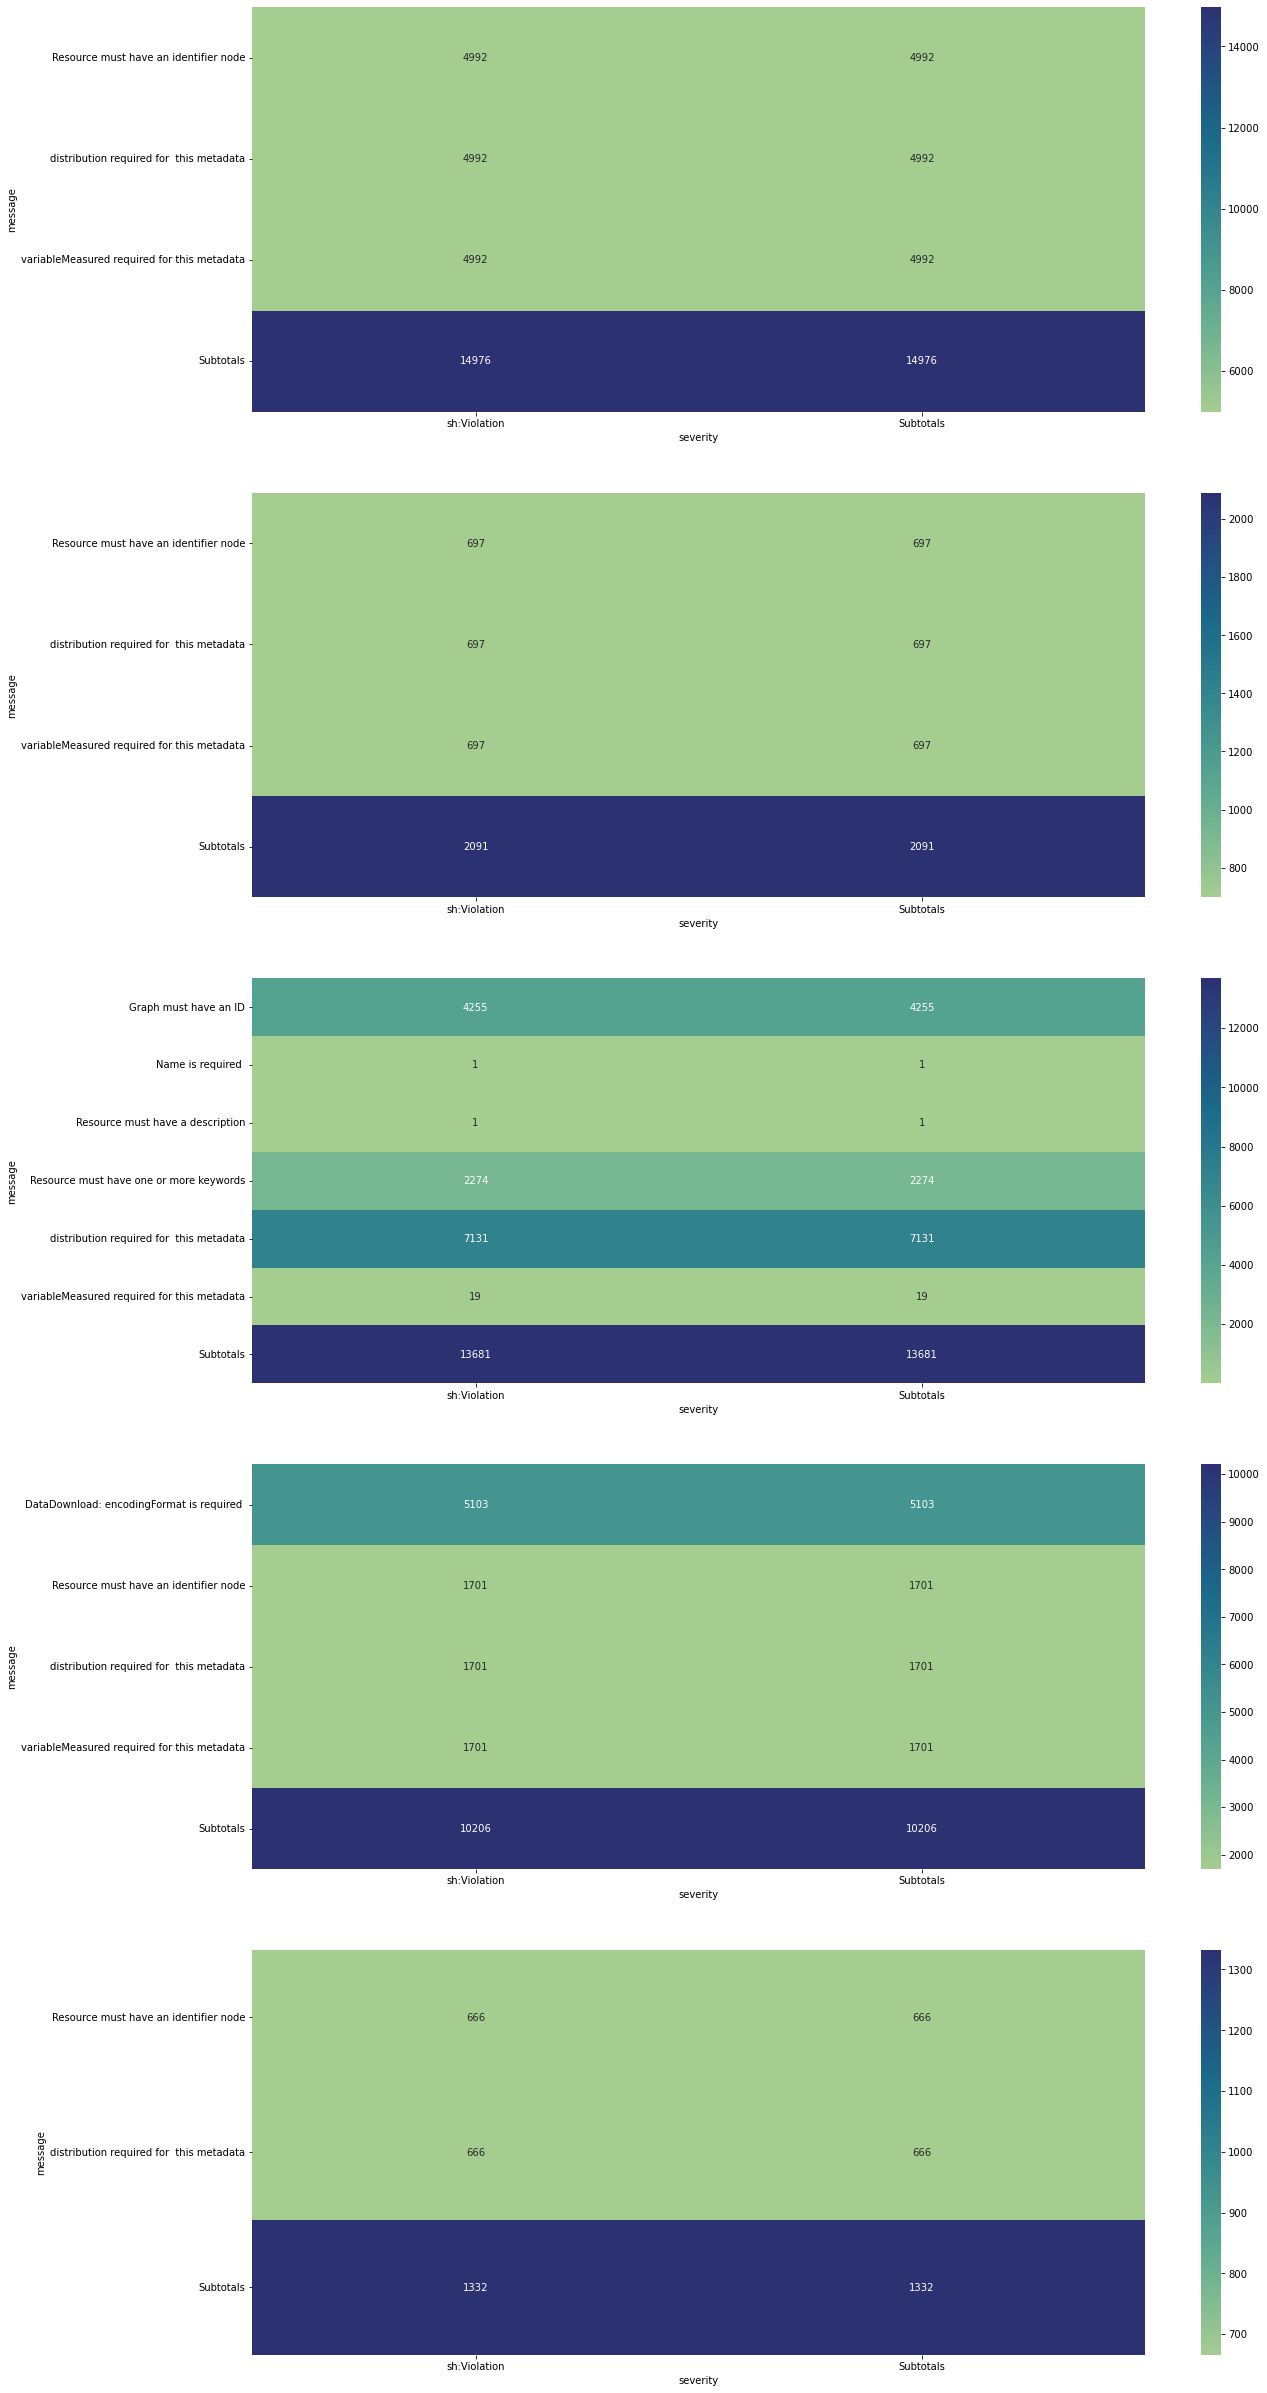

In [29]:
sparql = """
SELECT ?path ?value ?constraint ?severity ?message ?id ?focus
  WHERE {
    ?id rdf:type shacl:ValidationResult .
    ?id shacl:focusNode ?focus .
    ?id shacl:resultMessage ?message .
    ?id shacl:resultSeverity ?severity .
    ?id shacl:sourceConstraintComponent ?constraint .
    OPTIONAL {
        ?id shacl:resultPath ?path .
    }
    OPTIONAL {
        ?id shacl:value ?value .
    }
  }
"""

for k in allgraphs:
    pdf = k.query_as_df(sparql)
    df = pdf.to_pandas()
    df.style.background_gradient(cmap='Blues')

    if len(df) > 0 :
        dfc = df.groupby('severity').count().reset_index().rename(columns={'path': 'Count'})
        ctst = pd.crosstab(df['message'], df['severity'], margins = True, margins_name = 'Subtotals')

        print("Checking {} objects in {}".format("len of original bucket","NAME" ))
        print(ctst)
        print("-----------------------------------------")

# fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# fig.suptitle('test results')
i = 1
plt.subplots(figsize=(20, 70))

for k in allgraphs:
    # TODO put a try in here...  
    pdf = k.query_as_df(sparql)
    df = pdf.to_pandas()
    df.style.background_gradient(cmap='Blues')

    if len(df) > 0 :
        dfc = df.groupby('severity').count().reset_index().rename(columns={'path': 'Count'})
        ctst = pd.crosstab(df['message'], df['severity'], margins = True, margins_name = 'Subtotals')

        # sns.set(rc={'figure.figsize':(11.7,8.27)})
        plt.subplot(len(allgraphs),1,i)
        sns.heatmap(ctst, annot=True, fmt=".0f", cmap = sns.cm.crest)
        # axes[i].set_title(i)
        i+=1

plt.show()